<a href="https://colab.research.google.com/github/daniiomir/titanic_kaggle/blob/master/tatanic_kaggle_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install catboost

     |████████████████████████████████| 64.4MB 61kB/s 


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import catboost

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [30]:
data = pd.read_csv('drive/My Drive/Colab Notebooks/data_titanic/train.csv')
data.head()
# data.shape

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
for i in data.columns:
  print(i)

PassengerId
Survived
Pclass
Name
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [7]:
test_data = pd.read_csv('drive/My Drive/Colab Notebooks/data_titanic/test.csv')
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [0]:
X = data.drop('Survived', axis=1)
y = data['Survived']

In [9]:
X.head()
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# **Обработка и очищение данных**

In [0]:
def num_sex(sex):
  if sex == 'male':
    return 1
  else:
    return 2

In [0]:
def data_preparation(raw_data):
  raw_data['Sex_num'] = raw_data['Sex'].apply(num_sex)
  # raw_data['Family'] = raw_data['SibSp'] + raw_data['Parch']
  raw_data_cat = pd.get_dummies(raw_data.Embarked)
  new_data = pd.concat([raw_data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_num']], raw_data_cat], axis=1)
  return new_data

In [0]:
def data_preparation_full(raw_data):
  if int(raw_data['Fare'].isnull().sum()) > 0:
    raw_data.Fare.fillna(raw_data.Fare.mean(), inplace=True)
  if int(raw_data['Cabin'].isnull().sum()) > 0:
    raw_data.Cabin.fillna('-42', inplace=True)
  if int(raw_data['Embarked'].isnull().sum()) > 0:
    raw_data.Embarked.fillna('-42', inplace=True)
  raw_data.Age.fillna(raw_data.Age.mean(), inplace=True)
  return raw_data

In [13]:
prepared_train_data = data_preparation_full(X.copy())
prepared_train_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,-42,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,-42,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,-42,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,-42,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,-42,S
889,890,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C


In [14]:
prepared_train_data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [15]:
prepared_test_data = data_preparation_full(test_data.copy())
prepared_test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,-42,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,-42,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,-42,Q
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,-42,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,-42,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,-42,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,-42,S
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,-42,S


In [16]:
prepared_test_data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [0]:
categorical_features_indices = np.where(prepared_train_data.dtypes == object)[0]

In [18]:
categorical_features_indices

array([ 2,  3,  7,  9, 10])

In [19]:
prepared_train_data.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# **Визуализация данных**

In [0]:
for_viz = prepared_train_data.copy()
for_viz['Survived'] = y

In [0]:
for_viz['Sex_num'] = for_viz['Sex'].apply(num_sex)

In [72]:
for_viz.drop(['PassengerId'], axis=1).describe()

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_num
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838,1.352413
std,0.836071,13.002015,1.102743,0.806057,49.693429,0.486592,0.477990
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,1.000000
50%,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000,1.000000
75%,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,2.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,2.000000


In [60]:
for_viz.drop(['PassengerId'], axis=1).corr()

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_num
Pclass,1.000000,-0.331339,0.083081,0.018443,-0.549500,-0.338481,-0.131900
Age,-0.331339,1.000000,-0.232625,-0.179191,0.091566,-0.069809,-0.084153
SibSp,0.083081,-0.232625,1.000000,0.414838,0.159651,-0.035322,0.114631
Parch,0.018443,-0.179191,0.414838,1.000000,0.216225,0.081629,0.245489
Fare,-0.549500,0.091566,0.159651,0.216225,1.000000,0.257307,0.182333
Survived,-0.338481,-0.069809,-0.035322,0.081629,0.257307,1.000000,0.543351
Sex_num,-0.131900,-0.084153,0.114631,0.245489,0.182333,0.543351,1.000000


In [63]:
for_viz.drop(['PassengerId', 'Survived'], axis=1).corrwith(for_viz['Survived'])

Pclass    -0.338481
Age       -0.069809
SibSp     -0.035322
Parch      0.081629
Fare       0.257307
Sex_num    0.543351
dtype: float64

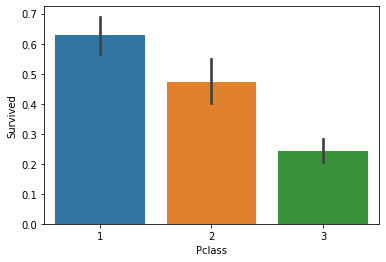

In [62]:
sns.barplot(x='Pclass', y='Survived', data=for_viz);

In [65]:
for_viz[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


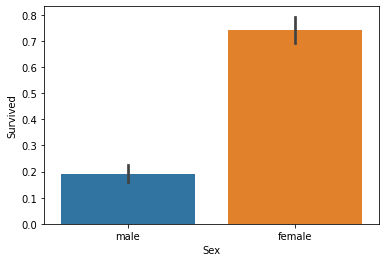

In [35]:
sns.barplot(x='Sex', y='Survived', data=for_viz);

In [67]:
for_viz[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


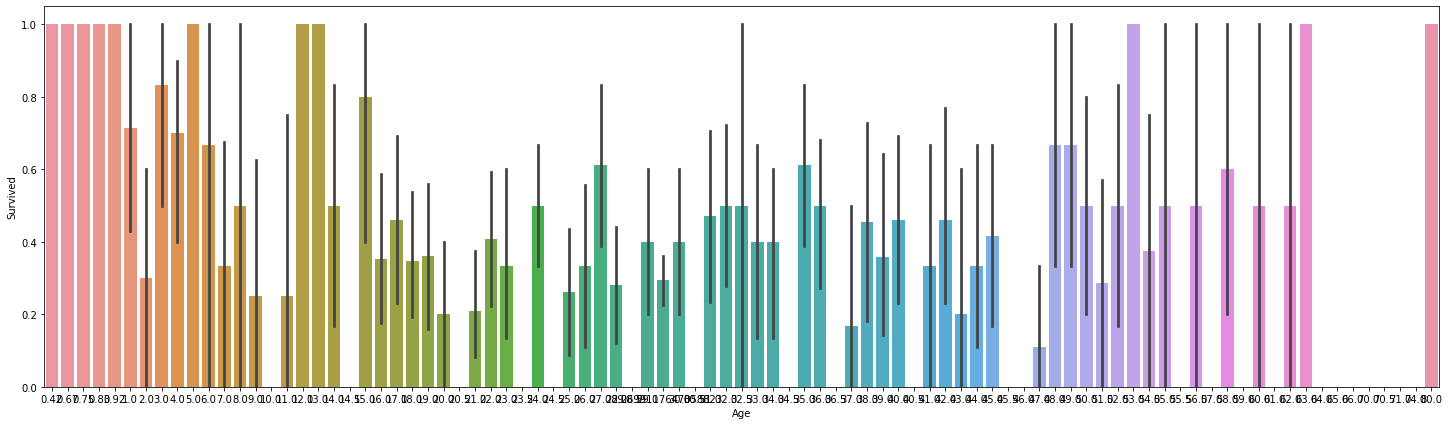

In [46]:
plt.figure(figsize=(25, 7))
sns.barplot(x='Age', y='Survived', data=for_viz);

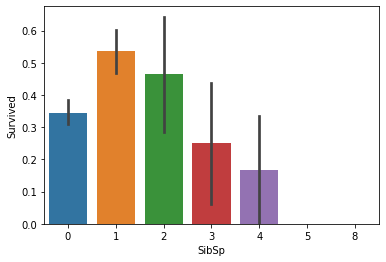

In [36]:
sns.barplot(x='SibSp', y='Survived', data=for_viz);

In [68]:
for_viz[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


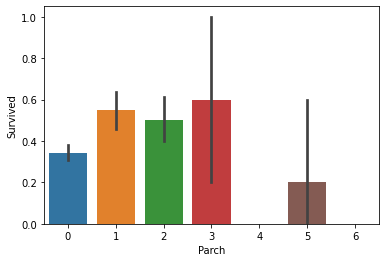

In [37]:
sns.barplot(x='Parch', y='Survived', data=for_viz);

In [69]:
for_viz[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


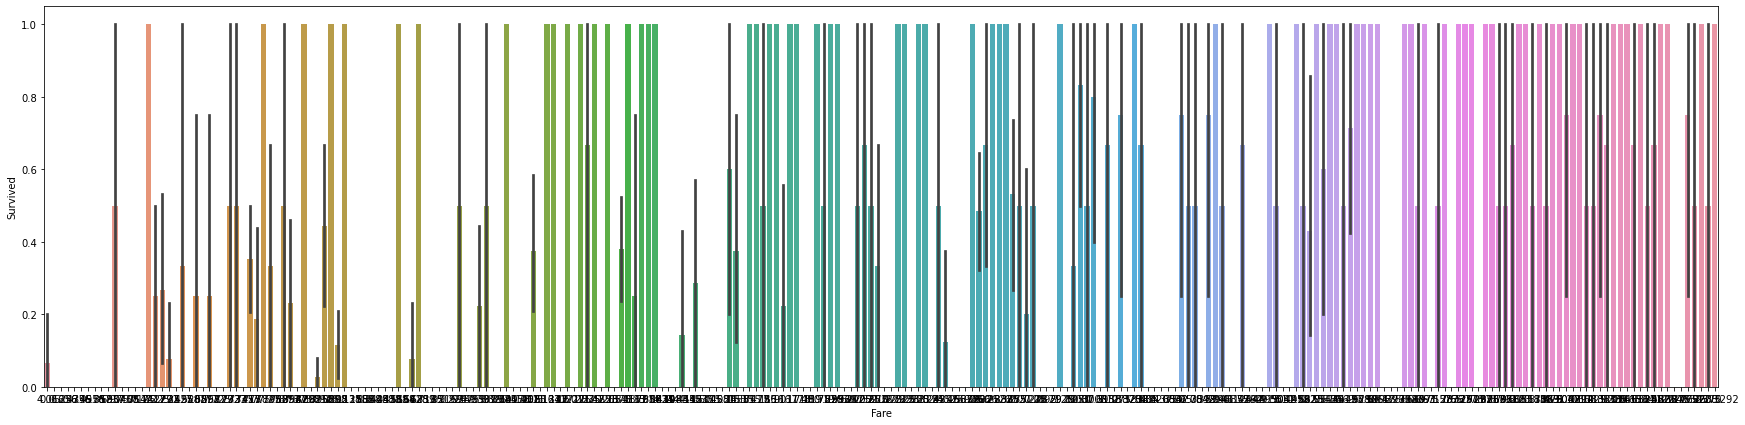

In [49]:
plt.figure(figsize=(30, 7))
sns.barplot(x='Fare', y='Survived', data=for_viz);

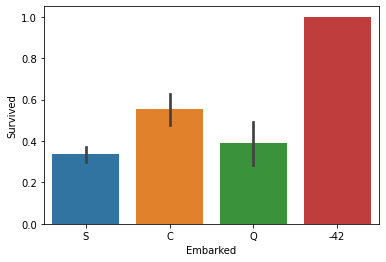

In [64]:
sns.barplot(x='Embarked', y='Survived', data=for_viz);

In [70]:
for_viz[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,-42,1.000000
1,C,0.553571
2,Q,0.389610
3,S,0.336957


# **Первая модель**

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [0]:
X_train, X_validation, y_train, y_validation = train_test_split(prepared_train_data, y, train_size=0.75, random_state=42)

# Catboost

In [0]:
model = catboost.CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [76]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    # logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [84]:
for i, j in zip(prepared_train_data.columns, model.feature_importances_):
  print(i, j)

PassengerId 5.2648182001648935
Pclass 15.0786241826928
Name 0.0
Sex 38.237961934799046
Age 10.099562833269966
SibSp 2.4090801714366306
Parch 1.4713565230041743
Ticket 6.7158615128682175
Fare 6.433549479404665
Cabin 7.182246030459222
Embarked 7.106939131900393


In [0]:
answer = model.predict(X_validation)

In [96]:
accuracy_score(y_validation, model.predict(X_validation))

0.8340807174887892

In [97]:
roc_auc_score(y_validation, answer)

0.8147744423947677

# RandomForest

In [0]:
prepared_train_data_rf = data_preparation(prepared_train_data.copy())
prepared_test_data_rf = data_preparation(prepared_test_data.copy())

In [0]:
X_train_rf, X_validation_rf, y_train_rf, y_validation_rf = train_test_split(prepared_train_data_rf, y, train_size=0.75, random_state=42)

In [0]:
model2 = RandomForestClassifier(random_state=42)

In [92]:
model2.fit(X_train_rf, y_train_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [111]:
for i, j in zip(prepared_train_data_rf.columns, model2.feature_importances_):
  print(i, j)

Pclass 0.07916886338991164
Age 0.2531961654955593
SibSp 0.0507361209258077
Parch 0.03917180075096612
Fare 0.27046835424616517
Sex_num 0.26780053111009816
-42 0.00016774156836500548
C 0.015162374588752248
Q 0.007518680900067085
S 0.01660936702430754


In [0]:
answer2 = model2.predict(X_validation_rf)

In [108]:
accuracy_score(y_validation_rf, answer2)

0.7802690582959642

In [101]:
roc_auc_score(y_validation_rf, answer2)

0.7737715914807982

# LogisticRegression

In [0]:
model3 = LogisticRegression(random_state=42)

In [104]:
model3.fit(X_train_rf, y_train_rf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [118]:
for i, j in zip(prepared_train_data_rf.columns, np.abs(model3.coef_)[0]): # feature importance
  print(i, j)

Pclass 0.9522940711384973
Age 0.03514363724052909
SibSp 0.2615605148173687
Parch 0.1121561120647603
Fare 0.003148974731253807
Sex_num 2.528414965863245
-42 0.08712030494642588
C 0.0098075042491834
Q 0.0279782366394343
S 0.4253648539487078


In [0]:
answer3 = model3.predict(X_validation_rf)

In [109]:
accuracy_score(y_validation_rf,answer3)

0.8026905829596412

In [110]:
roc_auc_score(y_validation_rf, answer3)

0.7905416736542009

# cross_validation

In [0]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = catboost.cv(
    catboost.Pool(prepared_train_data, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [0]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.83±0.02 on step 109


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


In [0]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.8338945005611672


In [0]:
predictions = model.predict(prepared_test_data)
predictions_probs = model.predict_proba(prepared_test_data)
print(predictions[:10])
print(predictions_probs[:10])

[0 0 0 0 1 0 1 0 1 0]
[[0.90132028 0.09867972]
 [0.63168188 0.36831812]
 [0.9018529  0.0981471 ]
 [0.91060524 0.08939476]
 [0.36689132 0.63310868]
 [0.83578542 0.16421458]
 [0.40804673 0.59195327]
 [0.89010723 0.10989277]
 [0.33523409 0.66476591]
 [0.97081175 0.02918825]]


In [0]:
sub = pd.DataFrame({'PassengerId':test_data['PassengerId'], 'Survived':predictions.astype(int)})
sub.to_csv('titanic_sub.csv', index=False)

In [0]:
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
